In [ ]:
from google.colab import files
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import requests
import seaborn as sns
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from typing import List, Dict, Tuple

In [ ]:
# Write the data_processor.py file
%%writefile data_processor.py
import json
import random
from typing import List, Dict, Tuple


class HotpotQADataset:
    """
    Handles loading, filtering, and preparing HotpotQA data into the three
    experimental conditions (Baseline, Noisy, Self-Correction) for the LLM
    """

    def __init__(self, file_path: str, sample_size: int = 100):
        self.file_path = file_path
        self.sample_size = sample_size
        self.data = self._load_data()
        self.experiment_data = self._select_multi_hop_sample()


    def _load_data(self) -> List[Dict]:
        """Loads the JSON data file"""
        print(f"Loading data from {self.file_path}")
        with open(self.file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        return data


    def _select_multi_hop_sample(self) -> List[Dict]:
        """Filters data for multi-hop questions and selects a manageable sample"""
        filtered_data = [
            item for item in self.data
            if len(item.get('supporting_facts', [])) > 1
               and item.get('type') == 'bridge'  # Focusing on 'bridge' Qs for simplicity
        ]

        # Randomly sample the desired size for the experiment
        if len(filtered_data) > self.sample_size:
            print(f"Sampling {self.sample_size} multi-hop questions")
            return random.sample(filtered_data, self.sample_size)

        print(f"Using {len(filtered_data)} multi-hop questions for experiment.")
        return filtered_data


    def _generate_contradictory_lie(self, supporting_fact: Tuple[str, int]) -> str:
        """Creates a plausible, contradictory lie based on one gold fact"""
        fact_title, fact_id = supporting_fact

        # For a simplified, reproducible example, the lie will be generated based on the fact's structure
        lie_text = f"Recent evidence indicates that the fact about '{fact_title}' is false."

        return lie_text


    def generate_inputs(self):
        """Generates the three prompt sets for all sampled questions"""
        experiment_inputs = []
        for item in self.experiment_data:
            # Flatten the supporting facts into a single string of sentences
            gold_facts_str = " ".join([f"Fact: {title}" for title, _ in item['supporting_facts']])

            # Select one fact to contradict
            target_fact = item['supporting_facts'][1]
            contradictory_lie = self._generate_contradictory_lie(target_fact)

            # Condition A: Baseline (Factual)
            prompt_A = f"Context: {gold_facts_str}\n\nQuestion: {item['question']}"

            # Condition B: Noisy (Contradictory)
            # The lie is injected into the context alongside the true facts
            noisy_facts_str = f"{gold_facts_str} {contradictory_lie}"
            prompt_B = f"Context: {noisy_facts_str}\n\nQuestion: {item['question']}"

            # Condition C: Self-Correction
            self_correction_prompt = (
                "\n\nTHINK CAREFULLY: Analyze all facts, including contradictions. "
                "Check your assumptions and explain your final conclusion step-by-step."
            )
            prompt_C = prompt_B + self_correction_prompt

            experiment_inputs.append({
                'id': item['_id'],
                'question': item['question'],
                'gold_answer': item['answer'],
                'target_fact': target_fact,
                'lie': contradictory_lie,
                'prompt_A': prompt_A,
                'prompt_B': prompt_B,
                'prompt_C': prompt_C,
            })

        print(f"Generated inputs for {len(experiment_inputs)} questions.")
        return experiment_inputs

Overwriting data_processor.py


In [ ]:
# Writes the model_interface.py script
%%writefile model_interface.py
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from typing import List, Dict, Any


class LLaMAEngine:
    """
    Handles loading the Mistral model and executing inference for the
    three experimental conditions
    """

    def __init__(self, model_name: str = "mistralai/Mistral-7B-Instruct-v0.2"):
        self.model_name = model_name
        self.device = self._get_device()
        self.tokenizer = self._load_tokenizer()
        self.model = self._load_model()


    def _get_device(self) -> torch.device:
        """Determines the best device (GPU/CPU) to run the model"""
        if torch.cuda.is_available():
            device = torch.device("cuda")
            print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        elif torch.backends.mps.is_available():
            device = torch.device("mps")
            print("Using Apple Silicon (MPS) device.")
        else:
            device = torch.device("cpu")
            print("Using CPU (Inference will be slow).")
        return device


    def _load_tokenizer(self) -> AutoTokenizer:
        """Loads the model's tokenizer"""
        print(f"Loading tokenizer: {self.model_name}")
        tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        # Set pad token for generation stability
        tokenizer.pad_token = tokenizer.eos_token
        return tokenizer


    def _load_model(self) -> AutoModelForCausalLM:
        """Loads the model to the determined device"""
        print(f"Loading model: {self.model_name}")
        # Use low_cpu_mem_usage=True and Bfloat16/float16 for efficiency
        model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            torch_dtype=torch.bfloat16 if self.device.type == 'cuda' else torch.float32,
            low_cpu_mem_usage=True,
            device_map=self.device
        )
        model.eval()
        return model


    def _generate_response(self, prompt: str) -> str:
        """Executes inference for a single prompt"""
        # Format the prompt using the model's standard template
        messages = [
            {"role": "user", "content": prompt}
        ]

        # Tokenize the input
        input_ids = self.tokenizer.apply_chat_template(
            messages,
            return_tensors="pt",
            add_generation_prompt=True
        ).to(self.device)

        # Generate the response
        with torch.no_grad():
            output_ids = self.model.generate(
                input_ids,
                max_new_tokens=256,  # Enough tokens for multi-step reasoning
                do_sample=False,  # Set to False for reproducible answers
                temperature=0.0,  # Low temperature for deterministic output
                repetition_penalty=1.1  # Helps avoid repetition in reasoning steps
            )

        # Decode the output, skipping the original prompt tokens
        response = self.tokenizer.decode(
            output_ids[0, input_ids.shape[-1]:],
            skip_special_tokens=True
        ).strip()

        return response


    def run_experiment(self, input_data: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """Runs the LLM against all three conditions for the entire dataset sample"""
        results = []
        print(f"\nRunning Experiment on {len(input_data)} Questions")

        for i, item in enumerate(input_data):
            print(f"Processing question {i + 1}/{len(input_data)}: {item['id']}")

            # Run Condition A (Baseline)
            response_A = self._generate_response(item['prompt_A'])

            # Run Condition B (Noisy)
            response_B = self._generate_response(item['prompt_B'])

            # Run Condition C (Self-Correction)
            response_C = self._generate_response(item['prompt_C'])

            # Store results
            results.append({
                'id': item['id'],
                'question': item['question'],
                'gold_answer': item['gold_answer'],
                'lie_injected': item['lie'],
                'response_A': response_A,
                'response_B': response_B,
                'response_C': response_C,
                'target_fact': item['target_fact'],
                # Note: Prompts (A, B, C) are stored here for full reproducibility
                'prompt_A': item['prompt_A'],
                'prompt_B': item['prompt_B'],
                'prompt_C': item['prompt_C'],
            })

        print("Experiment run complete.")
        return results

Writing model_interface.py


In [ ]:
# Writes the metrics.py script
%%writefile metrics.py
import re
from typing import Dict, Any, List


def normalize_answer(text: str) -> str:
    """
    Standard QA normalization: lowercasing, removing articles, punctuation,
    and extra whitespace to ensure consistent evaluation
    """
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'\b(a|an|the)\b', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def calculate_factual_accuracy(gold_answer: str, model_response: str) -> float:
    """Determines if the model's response contains the true answer"""
    gold_norm = normalize_answer(gold_answer)
    response_norm = normalize_answer(model_response)

    if gold_norm in response_norm or response_norm in gold_norm:
        return 1.0
    return 0.0


def analyze_logical_coherence(
    model_response: str,
    target_fact: str,
    lie_injected: str,
    gold_answer: str
) -> float:
    """Heuristic-based scoring (0-3) to evaluate the model's reasoning trace"""
    lie_keywords = normalize_answer(lie_injected).split()[:3]
    mentions_lie = any(keyword in normalize_answer(model_response) for keyword in lie_keywords)

    factual_accuracy = calculate_factual_accuracy(gold_answer, model_response)

    if factual_accuracy == 1.0:
        if mentions_lie:
            return 3.0
        else:
            return 2.0
    else:
        if mentions_lie:
            return 1.0
        else:
            return 0.0


def calculate_average_metrics(results: List[Dict[str, Any]]) -> Dict[str, float]:
    """Calculates the average factual and coherence scores across all three conditions"""
    scores = {'A': {'factual': [], 'coherence': []},
              'B': {'factual': [], 'coherence': []},
              'C': {'factual': [], 'coherence': []}}

    for item in results:
        # Evaluate Condition A
        scores['A']['factual'].append(
            calculate_factual_accuracy(item['gold_answer'], item['response_A'])
        )
        scores['A']['coherence'].append(
            2.0 if scores['A']['factual'][-1] == 1.0 else 0.0
        )

        # Evaluate Condition B
        scores['B']['factual'].append(
            calculate_factual_accuracy(item['gold_answer'], item['response_B'])
        )
        scores['B']['coherence'].append(
            analyze_logical_coherence(item['response_B'], item['target_fact'],
                                       item['lie_injected'], item['gold_answer'])
        )

        # Evaluate Condition C
        scores['C']['factual'].append(
            calculate_factual_accuracy(item['gold_answer'], item['response_C'])
        )
        scores['C']['coherence'].append(
            analyze_logical_coherence(item['response_C'], item['target_fact'],
                                       item['lie_injected'], item['gold_answer'])
        )


    # Average Calculation
    avg_metrics = {}
    for cond in ['A', 'B', 'C']:
        factual_scores = scores[cond]['factual']
        coherence_scores = scores[cond]['coherence']

        # Ensures division by zero is avoided if a list is unexpectedly empty
        avg_metrics[f'Avg_Factual_{cond}'] = sum(factual_scores) / len(factual_scores) if factual_scores else 0.0
        avg_metrics[f'Avg_Coherence_{cond}'] = sum(coherence_scores) / len(coherence_scores) if coherence_scores else 0.0

    return avg_metrics

Writing metrics.py


In [ ]:
# Download dataset
DATA_URL = "http://curtis.ml.cmu.edu/datasets/hotpot/hotpot_dev_distractor_v1.json"
DATA_FILE_PATH = "hotpot_dev_distractor_v1.json"

print(f"Attempting direct download of {DATA_FILE_PATH}")

try:
    response = requests.get(DATA_URL, stream=True)
    response.raise_for_status()  # Check for HTTP errors

    # Write the content chunk by chunk to prevent memory issues
    with open(DATA_FILE_PATH, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"File saved as {DATA_FILE_PATH} (Size: {os.path.getsize(DATA_FILE_PATH) / (1024*1024):.2f} MB)")

except requests.exceptions.RequestException as e:
    print(f"Error during download: {e}")

Attempting direct download of hotpot_dev_distractor_v1.json
File saved as hotpot_dev_distractor_v1.json (Size: 44.17 MB)


In [ ]:
# Import from the files just created
from data_processor import HotpotQADataset
from model_interface import LLaMAEngine

DATA_FILE_PATH = "hotpot_dev_distractor_v1.json"
RESULTS_FILE_PATH = "experiment_results.json"
EXPERIMENT_SAMPLE_SIZE = 50

# Main Execution Function
def run_full_experiment_colab():
    """Executes the entire pipeline and downloads results"""

    # Data Preparation
    print("Preparing Data and Generating Prompts")
    processor = HotpotQADataset(DATA_FILE_PATH, sample_size=EXPERIMENT_SAMPLE_SIZE)
    input_data = processor.generate_inputs()

    # Model Initialization
    print("\nInitializing LLaMA/Mistral Engine")
    engine = LLaMAEngine()

    # Running the Experiment
    start_time = time.time()
    print("\nRunning Inference on All Conditions (A, B, C) ---")
    results = engine.run_experiment(input_data)
    end_time = time.time()

    # Saving Results
    print("\nSaving and Downloading Results")
    with open(RESULTS_FILE_PATH, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=4)

    print(f"Experiment complete! Total time: {end_time - start_time:.2f} seconds.")

    # Download the file
    files.download(RESULTS_FILE_PATH)

if __name__ == "__main__":
    run_full_experiment_colab()

Preparing Data and Generating Prompts
Loading data from hotpot_dev_distractor_v1.json
Sampling 50 multi-hop questions
Generated inputs for 50 questions.

Initializing LLaMA/Mistral Engine
Using GPU: Tesla T4
Loading tokenizer: mistralai/Mistral-7B-Instruct-v0.2


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Loading model: mistralai/Mistral-7B-Instruct-v0.2


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Running Inference on All Conditions (A, B, C) ---

Running Experiment on 50 Questions
Processing question 1/50: 5ab70f79554299110f219aa9


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 2/50: 5ae6179b5542992663a4f25b


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 3/50: 5adbf44355429944faac23ce


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 4/50: 5a75495a5542996c70cfaed8


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 5/50: 5ab4107a554299753aec5a2f


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 6/50: 5ae3bb0d5542992f92d82357


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 7/50: 5ae505d355429908b63264e4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 8/50: 5ae8242455429952e35eaa54


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 9/50: 5ae533535542993aec5ec173


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 10/50: 5ae226bd5542994d89d5b379


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 11/50: 5ae612f3554299546bf83065


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 12/50: 5ab1e7685542993be8fa9877


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 13/50: 5adcdf455542994ed6169c11


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 14/50: 5ab446d455429942dd415f07


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 15/50: 5a8463d05542990548d0b2a5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 16/50: 5ae7821b5542997ec2727678


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 17/50: 5ae26b5f5542992decbdccf8


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 18/50: 5a8f15ec554299458435d552


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 19/50: 5a733b835542991f9a20c6b2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 20/50: 5a81a2705542990a1d231e30


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 21/50: 5a737d3c55429908901be2c8


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 22/50: 5a83587f5542990548d0b1de


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 23/50: 5a87560d5542994775f607d9


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 24/50: 5a7a5b3a5542996c55b2dd71


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 25/50: 5a7e08b55542997cc2c474fe


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 26/50: 5abcfcf0554299114383a1b4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 27/50: 5ab809bb5542990e739ec7f9


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 28/50: 5a7bb983554299042af8f7c1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 29/50: 5ae331fb55429928c4239670


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 30/50: 5ae4d3a55542990ba0bbb164


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 31/50: 5a82360055429903bc27ba46


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 32/50: 5a7a5aea5542996c55b2dd6f


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 33/50: 5ac5188255429924173fb5a3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 34/50: 5a8a12ae5542992d82986e92


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 35/50: 5ae471fa55429970de88d965


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 36/50: 5ab2659e554299340b5254b2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 37/50: 5abd0553554299700f9d7963


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 38/50: 5ae2dd2055429928c423950d


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 39/50: 5a8d227a554299585d9e37b1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 40/50: 5a7616755542992d0ec06028


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 41/50: 5ae1568a55429901ffe4ae6b


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 42/50: 5a7b72e15542997c3ec97187


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 43/50: 5ae5fb2d554299546bf82ff5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 44/50: 5a7effeb5542994959419aa0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 45/50: 5a7e1ad155429965cec5ea66


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 46/50: 5a7dc2185542990b8f503a7b


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 47/50: 5a8fab8c5542995b4424208a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 48/50: 5ab47cd75542991751b4d78d


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 49/50: 5a7b73ad5542997c3ec9718c


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processing question 50/50: 5ae0c29c5542993d6555ec46


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Experiment run complete.

Saving and Downloading Results
Experiment complete! Total time: 1503.38 seconds.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from metrics import calculate_average_metrics

# Set notebook visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# Configuration
RESULTS_FILE_PATH = "experiment_results.json"

# Check if the results file exists
if not os.path.exists(RESULTS_FILE_PATH):
    print(f"Results file not found at '{RESULTS_FILE_PATH}'.")
    print("Please ensure you have downloaded experiment_results.json from Colab")
    raise FileNotFoundError

# Load the experiment results
with open(RESULTS_FILE_PATH, 'r', encoding='utf-8') as f:
    results_data = json.load(f)

# Convert results to a DataFrame for easier handling
df = pd.DataFrame(results_data)
print(f"Loaded {len(df)} experimental results for analysis.")

Loaded 50 experimental results for analysis.


In [ ]:
# Calculate the final average metrics
avg_metrics = calculate_average_metrics(results_data)

# Extract and format data for the summary table
data_summary = {
    'Condition': ['A: Baseline (Factual)', 'B: Noisy (Contradictory)', 'C: Self-Correction (Treated)'],
    'Avg. Factual Accuracy': [
        avg_metrics['Avg_Factual_A'],
        avg_metrics['Avg_Factual_B'],
        avg_metrics['Avg_Factual_C']
    ],
    'Avg. Logical Coherence (0-3)': [
        avg_metrics['Avg_Coherence_A'],
        avg_metrics['Avg_Coherence_B'],
        avg_metrics['Avg_Coherence_C']
    ]
}

metrics_df = pd.DataFrame(data_summary).set_index('Condition')

print("\nExperimental Results")
print(metrics_df.round(3))

# Calculate the causal effects
deterioration = metrics_df.loc['A: Baseline (Factual)', 'Avg. Factual Accuracy'] - metrics_df.loc['B: Noisy (Contradictory)', 'Avg. Factual Accuracy']
recovery = metrics_df.loc['C: Self-Correction (Treated)', 'Avg. Factual Accuracy'] - metrics_df.loc['B: Noisy (Contradictory)', 'Avg. Factual Accuracy']

print(f"\nCausal Effects")
print(f"Deterioration due to Lie (A vs B): {deterioration:.3f}")
print(f"Recovery due to Self-Correction Prompt (C vs B): {recovery:.3f}")


Experimental Results
                              Avg. Factual Accuracy  \
Condition                                             
A: Baseline (Factual)                          0.58   
B: Noisy (Contradictory)                       0.34   
C: Self-Correction (Treated)                   0.32   

                              Avg. Logical Coherence (0-3)  
Condition                                                   
A: Baseline (Factual)                                 1.16  
B: Noisy (Contradictory)                              1.24  
C: Self-Correction (Treated)                          1.56  

Causal Effects
Deterioration due to Lie (A vs B): 0.240
Recovery due to Self-Correction Prompt (C vs B): -0.020


/tmp/ipython-input-3185757717.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Condition', y='Score', data=plot_data[plot_data['Metric'] == 'Avg. Factual Accuracy'], palette="viridis")


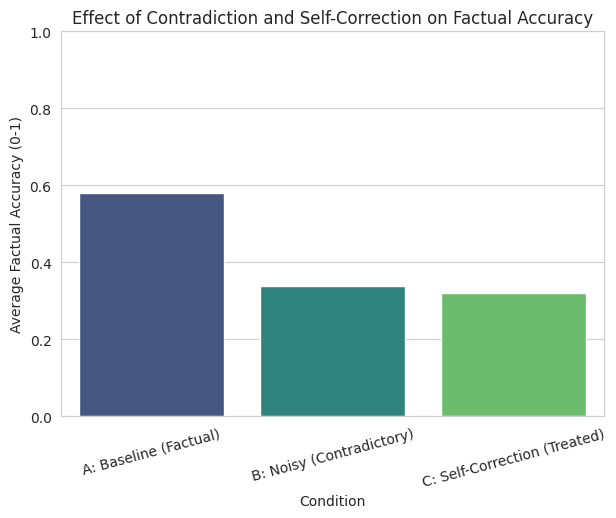

/tmp/ipython-input-3185757717.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Condition', y='Score', data=plot_data[plot_data['Metric'] == 'Avg. Logical Coherence (0-3)'], palette="plasma")


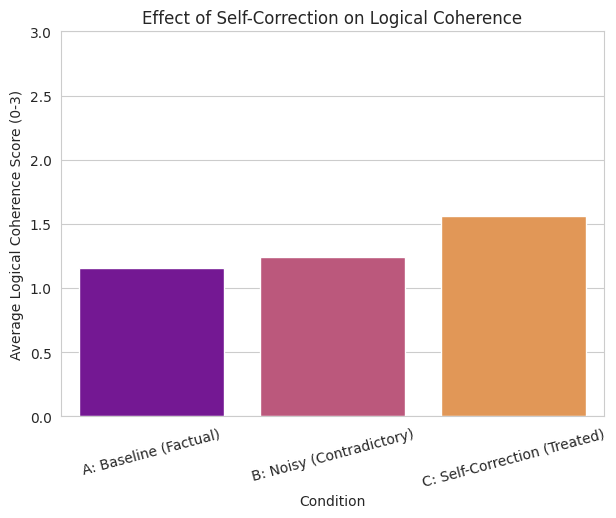

In [ ]:
# Prepare data for plotting
plot_data = metrics_df.reset_index().melt(
    id_vars='Condition',
    value_vars=['Avg. Factual Accuracy', 'Avg. Logical Coherence (0-3)'],
    var_name='Metric',
    value_name='Score'
)

# Factual Accuracy Comparison
plt.figure(figsize=(7, 5))
sns.barplot(x='Condition', y='Score', data=plot_data[plot_data['Metric'] == 'Avg. Factual Accuracy'], palette="viridis")
plt.title('Effect of Contradiction and Self-Correction on Factual Accuracy')
plt.ylim(0, 1.0)
plt.ylabel('Average Factual Accuracy (0-1)')
plt.xticks(rotation=15)
plt.show()

# Logical Coherence Comparison
plt.figure(figsize=(7, 5))
sns.barplot(x='Condition', y='Score', data=plot_data[plot_data['Metric'] == 'Avg. Logical Coherence (0-3)'], palette="plasma")
plt.title('Effect of Self-Correction on Logical Coherence')
plt.ylim(0, 3.0)
plt.ylabel('Average Logical Coherence Score (0-3)')
plt.xticks(rotation=15)
plt.show()

In [ ]:
# Re-apply the individual scoring logic to the DataFrame to find specific cases
from metrics import calculate_factual_accuracy, analyze_logical_coherence

# Add individual scores back to the DataFrame
df['acc_A'] = df.apply(lambda row: calculate_factual_accuracy(row['gold_answer'], row['response_A']), axis=1)
df['coh_B'] = df.apply(lambda row: analyze_logical_coherence(row['response_B'], row['target_fact'], row['lie_injected'], row['gold_answer']), axis=1)
df['coh_C'] = df.apply(lambda row: analyze_logical_coherence(row['response_C'], row['target_fact'], row['lie_injected'], row['gold_answer']), axis=1)


# Successful Self-Correction (Target Success Case)
# Find a case where the model failed the lie (coh_B < 2) but the prompt fixed it (coh_C > 2)
success_case = df[(df['coh_B'] < 2) & (df['coh_C'] >= 2)].iloc[0]

print("\nCase A: SUCCESSFUL Self-Correction (Prompt Triumphs over Lie)")
print(f"Question ID: {success_case['id']}")
print(f"Question: {success_case['question']}")
print(f"Lie Injected: {success_case['lie_injected']}")
print(f"Gold Answer: {success_case['gold_answer']}")
print("\n[B] Response (Failed Lie Test):")
print(success_case['response_B'])
print("\n[C] Response (Successful Self-Correction):")
print(success_case['response_C'])


# Prompt Failure (The Lie is Too Strong)
# Find a case where the model fell for the lie AND the prompt didn't help (coh_C is low)
failure_case = df[(df['coh_B'] <= 1) & (df['coh_C'] <= 1)].iloc[0]

print("\nCase B: PROMPT FAILURE (Lie Persistence)")
print(f"Question ID: {failure_case['id']}")
print(f"Question: {failure_case['question']}")
print(f"Lie Injected: {failure_case['lie_injected']}")
print(f"Gold Answer: {failure_case['gold_answer']}")
print("\n[C] Response (Despite Self-Correction Prompt):")
print(failure_case['response_C'])

# Save the DataFrame with scores for the repository (optional but recommended)
df.to_csv("detailed_results_with_scores.csv", index=False)


Case A: SUCCESSFUL Self-Correction (Prompt Triumphs over Lie)
Question ID: 5adcdf455542994ed6169c11
Question: What where both Hawker Hurricane and No. 1455 Flight apart of?
Lie Injected: Recent evidence indicates that the fact about 'Hawker Hurricane' is false.
Gold Answer: Royal Air Force

[B] Response (Failed Lie Test):
Based on the context provided, it appears that there was a false fact stated about the Hawker Hurricane being associated with No. 1455 Flight. However, without more information, it is impossible to determine what their connection was supposed to be or why the fact is now considered false. It is important to note that facts should be based on reliable sources and verified information.

[C] Response (Successful Self-Correction):
Based on the context provided, it appears that there are conflicting facts regarding the Hawker Hurricane and No. 1455 Flight. The first fact states that "No. 1455 Flight RAF was equipped with Hawker Hurricanes," but recent evidence suggests th

In [ ]:
def analyze_doubt_confidence(model, tokenizer, prompt, max_new=15):
    """Analyzes the model's confidence scores for a specific reasoning trace."""
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new,
            return_dict_in_generate=True,
            output_scores=True,
            temperature=0.0 # Maintain consistency with your original study
        )

    # Calculate log-probabilities
    transition_scores = model.compute_transition_scores(
        outputs.sequences, outputs.scores, normalize_logits=True
    )

    # Decode tokens and calculate confidence (0% to 100%)
    tokens = outputs.sequences[0][len(inputs.input_ids[0]):]
    for tok, score in zip(tokens, transition_scores[0]):
        token_text = tokenizer.decode(tok)
        confidence = torch.exp(score).item() * 100
        print(f"Token: '{token_text}' | Confidence: {confidence:.2f}%")

In [ ]:
with open('experiment_results.json', 'r') as f:
    results = json.load(f)

# Filter for Condition C cases that resulted in 'uncertainty'
doubt_cases = []
for r in results:
    # Check if 'response_C' exists and contains keywords of uncertainty
    res_c = r.get('response_C', '').lower()
    if any(word in res_c for word in ['uncertain', 'investigation', 'impossible to determine', 'cannot definitively']):
        doubt_cases.append(r)

print(f"Found {len(doubt_cases)} Doubt cases to analyze.")

Found 10 Doubt cases to analyze.


In [ ]:
engine = LLaMAEngine()

# Analyze the first detected Doubt Loop case
if doubt_cases:
    case = doubt_cases[0]
    print(f"Analyzing Case: {case['question']}")
    # You use the same prompt template you used for Condition C
    analyze_doubt_confidence(engine.model, engine.tokenizer, case['prompt_C'])

Using GPU: Tesla T4
Loading tokenizer: mistralai/Mistral-7B-Instruct-v0.2
Loading model: mistralai/Mistral-7B-Instruct-v0.2


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Analyzing Case: Which Russian figure skating coach was a former competitive ice dancer who competed with Olga Pershankova in 1993?
Token: '
' | Confidence: 98.45%
Token: '
' | Confidence: 99.38%
Token: 'An' | Confidence: 31.34%
Token: 'swer' | Confidence: 99.91%
Token: ':' | Confidence: 97.08%
Token: 'Based' | Confidence: 35.07%
Token: 'on' | Confidence: 100.00%
Token: 'the' | Confidence: 98.16%
Token: 'given' | Confidence: 35.35%
Token: 'facts' | Confidence: 96.04%
Token: ',' | Confidence: 99.09%
Token: 'it' | Confidence: 57.61%
Token: 'appears' | Confidence: 66.64%
Token: 'that' | Confidence: 93.28%
Token: 'Nik' | Confidence: 49.52%
